In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import neural_helpers as nh
np.random.seed(1)
%load_ext autoreload
%autoreload 2

bids_dir = '/Volumes/shohamy-locker/chris/hybrid_mri_bids'
nibs_dir = f'{bids_dir}/derivatives/nibetaseries'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
all_patterns = nh.get_all_roi_patterns('hipp') # all_patterns[sub_num]['choice/fb'] = array(~300 trials x ~400 vox)
# all_patterns = nh.get_all_roi_patterns('loc')  # (~300 trials x ~700 voxels)
# all_patterns = nh.get_all_roi_patterns('striatum')  # (~300 trials x ~900 voxels)
# all_patterns = nh.get_all_roi_patterns('vmpfc')  # (~300 trials x ~700 voxels)

What's happening in this task?

During choice: 
- Querying memory for if you remember an associated value with each card
	- Reinstate the value
	- Decide based on the retrieved value
- Pre-existing deck preference
	- Based on last trial, or Q aggregate

During feedback
- Associating reward with deck
	- Reinstating deck color
	- Reinstating choice object to bind

## vmPFC

### plots

feedback trial pattern seems to correlate with retrieval choice pattern 
- But, NOT related to choice
- and is also true for the ~3 trials after (not before) the retrieval trial
    - schema learning or something?

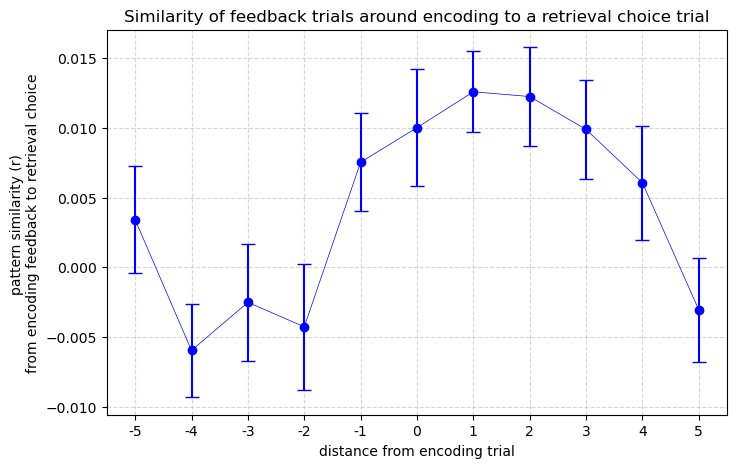

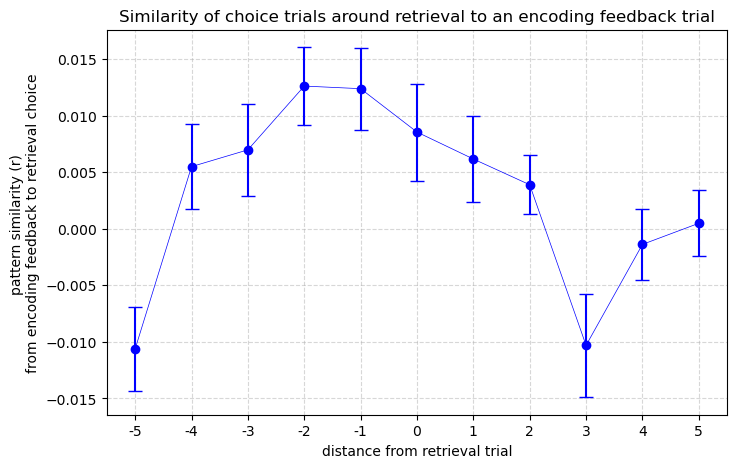

In [244]:
# does an encoding trial correlate to trials around the retrieval trial?

enc_to_ret = [] # correlate encoding feedback trial to trials all around the retrieval trial
ret_to_enc = [] # correlate retrieval choice to feedback trials around the encoding

for sub_num in range(1,32):
    sub_enc_to_ret, sub_ret_to_enc = [],[]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for (ret_idx,enc_idx) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[ret_idx] == 1 and beh_data.encTrialNum.iloc[ret_idx] == beh_data.Trial.iloc[enc_idx]:

            if 5 < enc_idx < len(beh_data) - 5:
                enc_window_vals = np.repeat(np.nan, 11) # 5 before encoding trial and 5 after
                for i,step in enumerate(range(-5,6)): 
                    enc_idx_to_check = enc_idx + step
                    enc_window_vals[i] = corr_matrix[ret_idx, enc_idx_to_check]

            if 5 < ret_idx < len(beh_data) - 5:
                ret_window_vals = np.repeat(np.nan, 11) 
                for i,step in enumerate(range(-5,6)): 
                    ret_idx_to_check = ret_idx + step
                    ret_window_vals[i] = corr_matrix[ret_idx_to_check, enc_idx]

            sub_enc_to_ret.append(enc_window_vals)
            sub_ret_to_enc.append(ret_window_vals)

    # get subject mean at each index and add to the group array 
    enc_to_ret.append(np.nanmean(sub_enc_to_ret, axis=0))
    ret_to_enc.append(np.nanmean(sub_ret_to_enc, axis=0))


nh.plot_enc_kernel(enc_to_ret, title = "Similarity of feedback trials around encoding to a retrieval choice trial",
                   xlabel='distance from encoding trial',
                   ylabel='pattern similarity (r) \nfrom encoding feedback to retrieval choice')
nh.plot_enc_kernel(ret_to_enc, title = "Similarity of choice trials around retrieval to an encoding feedback trial",
                   xlabel='distance from retrieval trial',
                   ylabel='pattern similarity (r) \nfrom encoding feedback to retrieval choice')

In [264]:
# what could be driving this lingering (and asymmetric) effect ?

# retrieval choice pattern to ALL encoding fb patterns, separate by 
#   1. was the current lucky deck, lucky then
#   2. same vs different reward outcome (and maybe reward difference)

luck_match, luck_mismatch = [],[]
reward_match, reward_mismatch = [],[]
reward_differences = [[],[],[],[],[],[]]

for sub_num in range(1,32):
    sub_luck_match, sub_luck_mismatch = [],[]
    sub_reward_match, sub_reward_mismatch = [],[]
    sub_reward_differences = [[],[],[],[],[],[]]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for (ret_idx,enc_idx) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[ret_idx] == 1 and beh_data.encT.iloc[enc_idx] == 1:
            # retrieval choice and encoding feedback

            if beh_data.LuckyDeck.iloc[ret_idx] == beh_data.LuckyDeck.iloc[enc_idx]:
                sub_luck_match.append(corr_matrix[ret_idx,enc_idx])
            else:
                sub_luck_mismatch.append(corr_matrix[ret_idx,enc_idx])

            if beh_data.ObjPP.iloc[ret_idx] == beh_data.Outcome.iloc[enc_idx]:
                sub_reward_match.append(corr_matrix[ret_idx,enc_idx])
            else:
                sub_reward_mismatch.append(corr_matrix[ret_idx,enc_idx])

            reward_diff = abs(beh_data.ObjPP.iloc[ret_idx] - beh_data.Outcome.iloc[enc_idx])
            idx = int(reward_diff*5 )
            sub_reward_differences[idx].append(corr_matrix[ret_idx,enc_idx])

    luck_match.append(np.mean(sub_luck_match))
    luck_mismatch.append(np.mean(sub_luck_mismatch))
    reward_match.append(np.mean(sub_reward_match))
    reward_mismatch.append(np.mean(sub_reward_mismatch))
    for i in range(len(reward_differences)):
        reward_differences[i].append(np.mean(sub_reward_differences[i]))

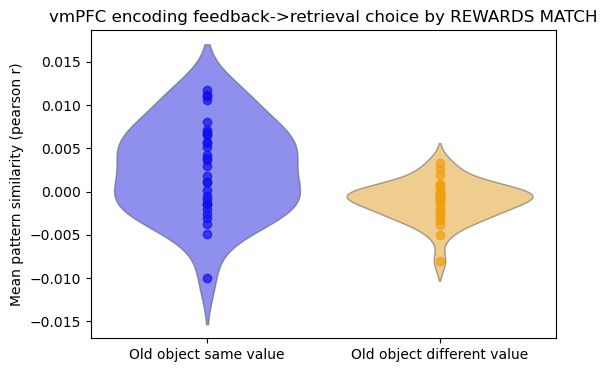

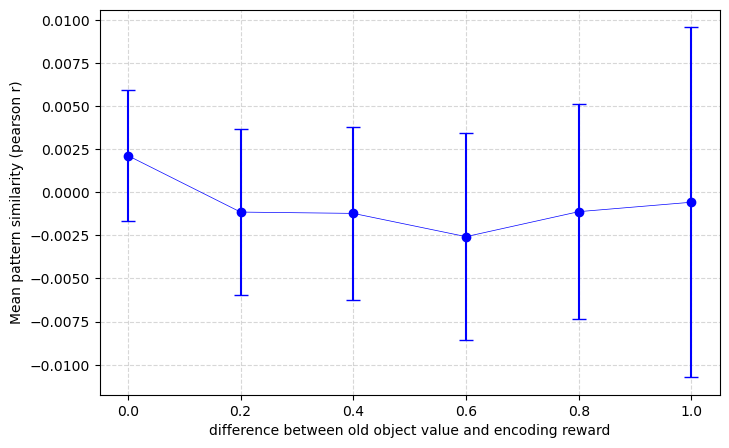

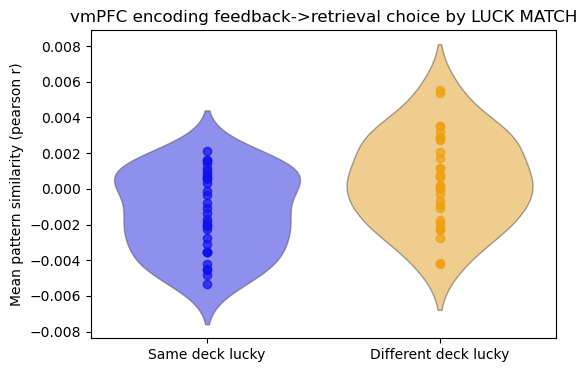

In [265]:
nh.simple_violin(reward_match, reward_mismatch,
              title = 'vmPFC encoding feedback->retrieval choice by REWARDS MATCH', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Old object same value', x2_label = 'Old object different value')
nh.simple_plot(reward_differences, x = [0,0.2,0.4,0.6,0.8,1.0],
               xlabel='difference between old object value and encoding reward', ylabel='Mean pattern similarity (pearson r)')
nh.simple_violin(luck_match, luck_mismatch,
              title = 'vmPFC encoding feedback->retrieval choice by LUCK MATCH', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Same deck lucky', x2_label = 'Different deck lucky')


### Hasty model

In [271]:
# all_patterns = nh.get_all_roi_patterns('hipp') # all_patterns[sub_num]['choice/fb'] = array(~300 trials x ~400 vox)
# all_patterns = nh.get_all_roi_patterns('loc')  # (~300 trials x ~700 voxels)
# all_patterns = nh.get_all_roi_patterns('striatum')  # (~300 trials x ~900 voxels)
all_patterns = nh.get_all_roi_patterns('vmpfc')  # (~300 trials x ~700 voxels)

In [274]:
test = {}
for sub,dict in all_patterns.items():
    test[sub] = {}
    for trial_type,data in dict.items():
        test[sub][trial_type] = np.random.rand(*all_patterns[sub][trial_type].shape)

In [ ]:
all_rows = []
for sub in range(1,32):
    beh_data = nh.get_beh_data(sub)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub, 'fb_to_choice')
    # encoding_trials = beh_data[beh_data.OldT==1]
    # retrieval_trials = beh_data[beh_data.OldT==1]
    for (i,j) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.OldT.iloc[j] == 0: # for now just include all encoding trials and all retrieval trials
            trials_from_encoding = abs(beh_data.encTrialNum.iloc[i] - beh_data.Trial.iloc[j])
            trials_from_encoding_sign = np.sign(beh_data.encTrialNum.iloc[i] - beh_data.Trial.iloc[j])
            all_rows.append({
                'corr_z': np.arctanh(corr_matrix[i,j]),
                'is_encoding_match': int(beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]),
                'is_reward_match': int(beh_data.ObjPP.iloc[i] == beh_data.Outcome.iloc[j]),
                'is_luck_match': int(beh_data.LuckyDeck.iloc[i] == beh_data.LuckyDeck.iloc[j]),
                'trials_in_between': beh_data.Trial.iloc[i] - beh_data.Trial.iloc[j],
                'trials_from_encoding': trials_from_encoding,
                'trials_from_encoding_sign': trials_from_encoding_sign,
                'trials_from_encoding_interaction': trials_from_encoding * trials_from_encoding_sign,
                'Sub': sub,
                'retrieval_trial': i,
                'encoding_trial':j
            })
df = pd.DataFrame(all_rows)

In [276]:
from pymer4.models import Lmer
model = Lmer(
    "corr_z ~  is_encoding_match + is_reward_match + is_luck_match + trials_in_between + " # trials_from_encoding + trials_from_encoding_sign + trials_from_encoding_interaction +
    "(1 | Sub)",
    data=df
)
model.fit()
print(model.summary())

/Users/chrisiyer/miniconda3/envs/hbi/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: corr_z~is_encoding_match+is_reward_match+is_luck_match+trials_in_between+(1|Sub)

Family: gaussian	 Inference: parametric

Number of observations: 339188	 Groups: {'Sub': 31.0}

Log-likelihood: 603454.173 	 AIC: -1206894.345

Random effects:

                 Name    Var    Std
Sub       (Intercept)  0.000  0.000
Residual               0.002  0.041

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: corr_z~is_encoding_match+is_reward_match+is_luck_match+trials_in_between+(1|Sub)

Family: gaussian	 Inference: parametric

Number of observations: 339188	 Groups: {'Sub': 31.0}

Log-likelihood: 603454.173 	 AIC: -1206894.345

Random effects:

                 Name    Var    Std
Sub       (Intercept)  0.000  0.000
Residual               0.002  0.041

No random effect correlations specified

Fixed effects:

                   Estimate  2.5_ci  97.5_ci     SE          DF  T-stat  \
(In

# Pattern analyses

### 1. Is correlation higher for encoding-retrieval pairs than unrelated pairs?

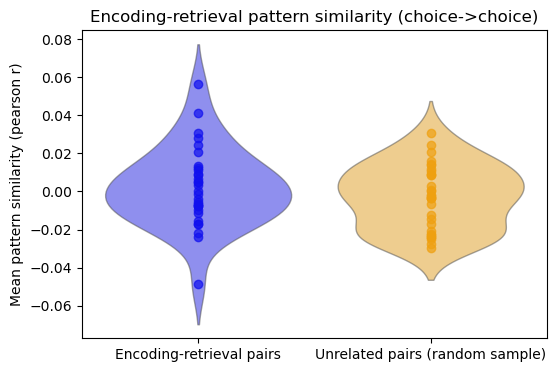

One sample t-test result: p = 0.5346742093940231


In [6]:
sub_avg_enc_ret_corr = []
sub_avg_unpair_corr = []

for sub_num in range(1,32):
    enc_ret_corr = []
    unpair_corr = []

    beh_data = nh.get_beh_data(sub_num)
    choice_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')

    enc_ret_corr = []
    unpair_corr = []
    for (i,j) in zip(*np.tril_indices_from(choice_corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
            enc_ret_corr.append(choice_corr_matrix[i,j])
        else:
            unpair_corr.append(choice_corr_matrix[i,j])

    # Randomly sample from unpaired correlations (equal size to enc-ret pairs)
    # not statistically appropriate but just for visualizating variance
    sampled_unpaired = np.random.choice(unpair_corr, size=len(enc_ret_corr), replace=False)

    sub_avg_enc_ret_corr.append(np.mean(enc_ret_corr))
    sub_avg_unpair_corr.append(np.mean(sampled_unpaired))

nh.simple_violin(sub_avg_enc_ret_corr, sub_avg_unpair_corr,
              title = 'Encoding-retrieval pattern similarity (choice->choice)', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Encoding-retrieval pairs', x2_label = 'Unrelated pairs (random sample)')

print('One sample t-test result: p =', scipy.stats.ttest_1samp(sub_avg_enc_ret_corr, 0).pvalue)

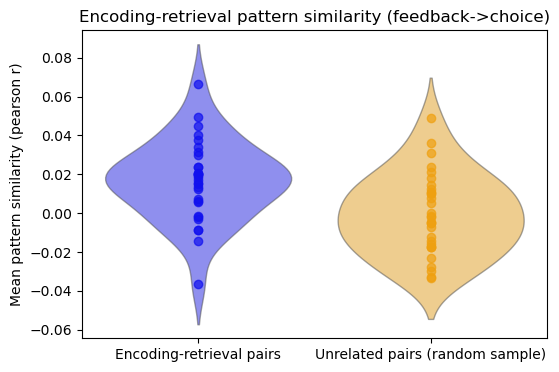

One sample t-test result: p = 8.60310002814303e-05


In [7]:
sub_avg_enc_ret_corr = []
sub_avg_unpair_corr = []

for sub_num in range(1,32):
    enc_ret_corr = []
    unpair_corr = []

    beh_data = nh.get_beh_data(sub_num)
    choice_fb_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'feedback_to_choice')

    enc_ret_corr = []
    unpair_corr = []
    for (i,j) in zip(*np.tril_indices_from(choice_fb_corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
            enc_ret_corr.append(choice_fb_corr_matrix[i,j])
        else:
            unpair_corr.append(choice_fb_corr_matrix[i,j])

    # Randomly sample from unpaired correlations (equal size to enc-ret pairs)
    # not statistically appropriate but just for visualizating variance
    sampled_unpaired = np.random.choice(unpair_corr, size=len(enc_ret_corr), replace=False)

    sub_avg_enc_ret_corr.append(np.mean(enc_ret_corr))
    sub_avg_unpair_corr.append(np.mean(sampled_unpaired))

nh.simple_violin(sub_avg_enc_ret_corr, sub_avg_unpair_corr,
              title = 'Encoding-retrieval pattern similarity (feedback->choice)', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Encoding-retrieval pairs', x2_label = 'Unrelated pairs (random sample)')

print('One sample t-test result: p =', scipy.stats.ttest_1samp(sub_avg_enc_ret_corr, 0).pvalue)

### 2. Does ERS predict memory choice? (Only mismatch trials)

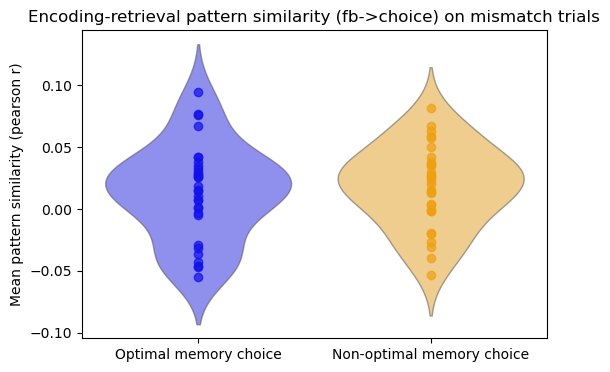

Two sample t-test result: p = 0.5590560678926773


In [209]:
ps_opt = []
ps_nonopt = []

for sub_num in range(1,32):
    sub_ps_opt = []
    sub_ps_nonopt = []

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice') # nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for (i,j) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j] and beh_data.ObjDeckMatch.iloc[i]==1:
            if beh_data.OptObj.iloc[i] == 1:
                sub_ps_opt.append(corr_matrix[i,j])
            else:
                sub_ps_nonopt.append(corr_matrix[i,j])

    ps_opt.append(np.mean(sub_ps_opt))
    ps_nonopt.append(np.mean(sub_ps_nonopt))

nh.simple_violin(ps_opt, ps_nonopt,
              title = 'Encoding-retrieval pattern similarity (fb->choice) on mismatch trials', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Optimal memory choice', x2_label = 'Non-optimal memory choice')
print('Two sample t-test result: p =', scipy.stats.ttest_rel(ps_opt, ps_nonopt).pvalue)

### 3. Similarity kernel of retrieval trial to those around encoding trial. Does this similarity predict old/new trial performance? old vs. new choices, optimal vs. nonoptimal

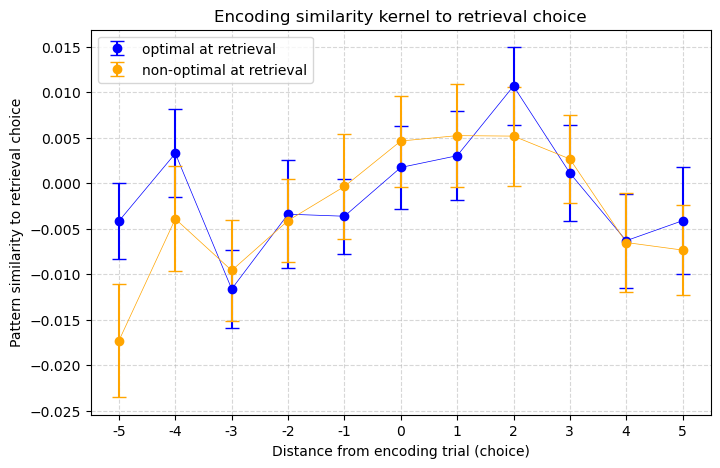

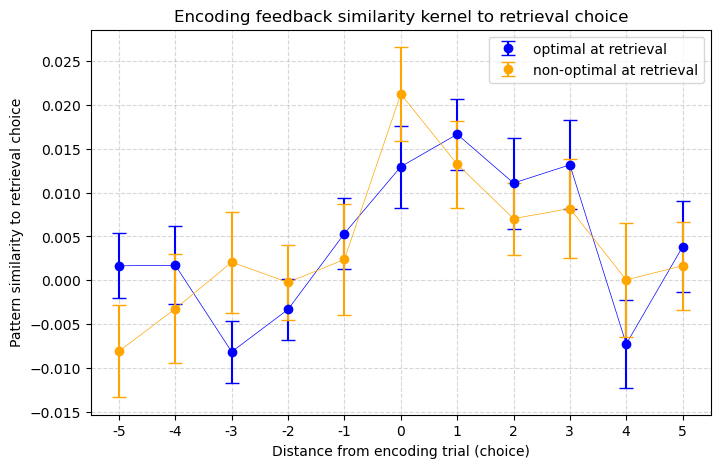

In [211]:
# for each old trial, get the pattern similarity to the encoding trial +- 5 trials
# separate optimal and non-optimal memory performance

enc_choice_kernel_ps_opt = [] 
enc_choice_kernel_ps_nonopt = [] 
enc_fb_kernel_ps_opt = [] 
enc_fb_kernel_ps_nonopt = [] 

for sub_num in range(1,32):
    subject_enc_choice_kernel_ps_opt = []
    subject_enc_choice_kernel_ps_nonopt = []
    subject_enc_fb_kernel_ps_opt = []
    subject_enc_fb_kernel_ps_nonopt = []

    beh_data = nh.get_beh_data(sub_num)
    choice_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')
    fb_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1:
            # get the index of the encoding trial (not the same as trial number in beh_data)
            if row.encTrialNum in beh_data.Trial.to_numpy(): # some invalid trials not here
                idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
                # get the 5 preceding and following trials
                ps_choice_window = np.repeat(np.nan, 11)
                ps_fb_window = np.repeat(np.nan, 11)
                # extract correlations for this window of trials
                for j,step in enumerate(range(-5,6)):
                    idx_to_check = idx_of_enc_trial + step
                    if idx_to_check >=0 and idx_to_check < len(beh_data):
                        ps_choice_window[j] = choice_corr_matrix[i, idx_to_check]
                        ps_fb_window[j] = fb_corr_matrix[i, idx_to_check]

            if row.OptObj==1:
                subject_enc_choice_kernel_ps_opt.append( ps_choice_window )
                subject_enc_fb_kernel_ps_opt.append( ps_fb_window )
            else:
                subject_enc_choice_kernel_ps_nonopt.append( ps_choice_window )
                subject_enc_fb_kernel_ps_nonopt.append( ps_fb_window )

    # take the subject mean at each delay index
    enc_choice_kernel_ps_opt.append( np.nanmean( subject_enc_choice_kernel_ps_opt, axis=0) )
    enc_choice_kernel_ps_nonopt.append( np.nanmean( subject_enc_choice_kernel_ps_nonopt, axis=0) )
    enc_fb_kernel_ps_opt.append( np.nanmean( subject_enc_fb_kernel_ps_opt, axis=0) )
    enc_fb_kernel_ps_nonopt.append( np.nanmean( subject_enc_fb_kernel_ps_nonopt, axis=0) )

nh.plot_enc_kernel(enc_choice_kernel_ps_opt, enc_choice_kernel_ps_nonopt, label1='optimal at retrieval', label2='non-optimal at retrieval',
                   title = "Encoding similarity kernel to retrieval choice")

nh.plot_enc_kernel(enc_fb_kernel_ps_opt, enc_fb_kernel_ps_nonopt, label1='optimal at retrieval', label2='non-optimal at retrieval',
                   title = "Encoding feedback similarity kernel to retrieval choice")

### 4. Encoding-retrieval similarity by delay

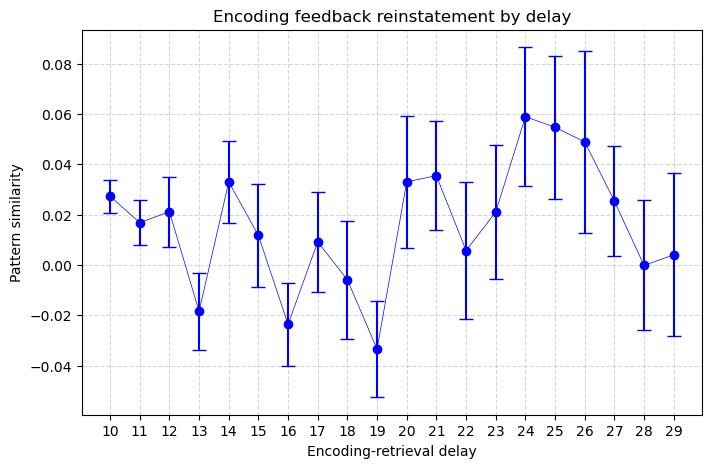

In [10]:
# are encoding trials more similar to retrieval trials the closer you are
# if so, is this above a delay-matched control?
from collections import defaultdict

delay_to_ps = defaultdict(list)
for sub_num in range(1,32):
    sub_delay_to_ps = defaultdict(list)
    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1 and row.encTrialNum in beh_data.Trial.to_numpy():
            idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
            ps = corr_matrix[i, idx_of_enc_trial]
            delay = str(row.Delay.astype(int))
            sub_delay_to_ps[delay].append(ps)
        
    for key,value in sub_delay_to_ps.items():
        delay_to_ps[key].append(np.mean(value))

nh.plot_ers_delay(dict(delay_to_ps),title='Encoding feedback reinstatement by delay', xlabel='Encoding-retrieval delay')

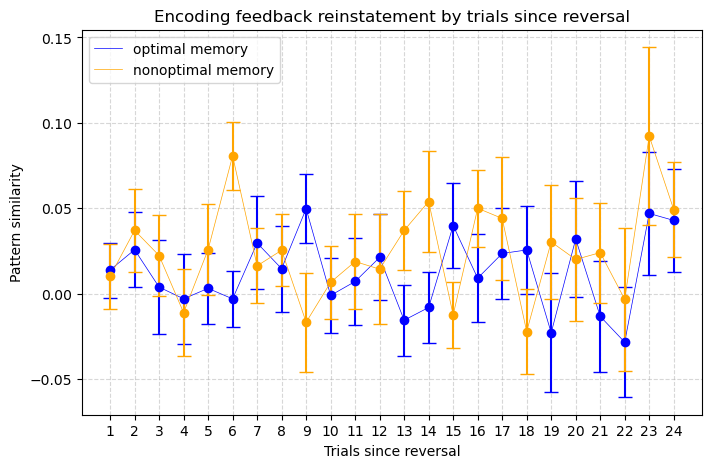

In [19]:
# do you get less ERS the further you go into reversal period?
# are encoding trials more similar to retrieval trials the closer you are
# if so, is this above a delay-matched control?

revt_to_ps_opt = defaultdict(list)
revt_to_ps_nonopt = defaultdict(list)

for sub_num in range(1,32):
    sub_revt_to_ps_opt = defaultdict(list)
    sub_revt_to_ps_nonopt = defaultdict(list)
    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1 and row.encTrialNum in beh_data.Trial.to_numpy():
            idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
            ps = corr_matrix[i, idx_of_enc_trial]
            revt = row.RevT.astype(int)

            if row.OptObj ==1:
                sub_revt_to_ps_opt[revt].append(ps)
            else:
                sub_revt_to_ps_nonopt[revt].append(ps)
        
    for key,value in sub_revt_to_ps_opt.items():
        revt_to_ps_opt[key].append(np.mean(value))
    for key,value in sub_revt_to_ps_nonopt.items():
        revt_to_ps_nonopt[key].append(np.mean(value))

nh.plot_revt_ps(dict(revt_to_ps_opt),dict(revt_to_ps_nonopt),
                title='Encoding feedback reinstatement by trials since reversal', xlabel='Trials since reversal')

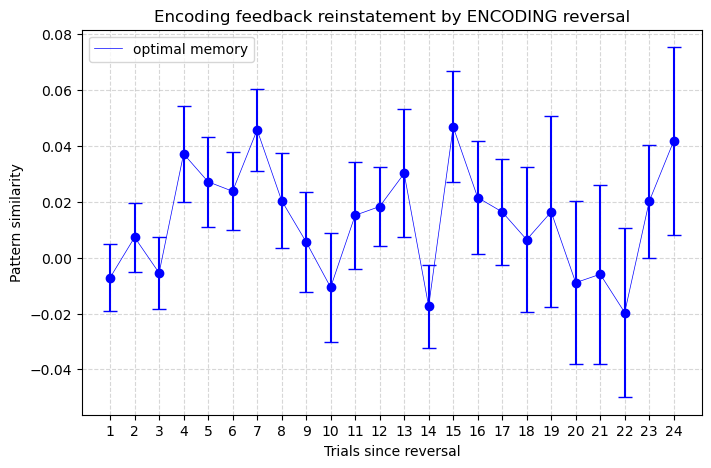

In [20]:
# do you get less ERS the further you go into ENCODING reversal period?
# are encoding trials more similar to retrieval trials the closer you are
# if so, is this above a delay-matched control?

revt_to_ps = defaultdict(list)

for sub_num in range(1,32):
    sub_revt_to_ps = defaultdict(list)
    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'fb_to_choice')

    for i,row in beh_data.iterrows():
        if row.OldT==1 and row.encTrialNum in beh_data.Trial.to_numpy():
            idx_of_enc_trial = beh_data.index[beh_data.Trial == row.encTrialNum][0]
            ps = corr_matrix[i, idx_of_enc_trial]
            revt = beh_data.RevT.iloc[idx_of_enc_trial].astype(int)

            sub_revt_to_ps[revt].append(ps)
        
    for key,value in sub_revt_to_ps.items():
        revt_to_ps[key].append(np.mean(value))

nh.plot_revt_ps(dict(revt_to_ps),
                title='Encoding feedback reinstatement by ENCODING reversal', xlabel='Trials since reversal')

### Similarity from one choice trial to it's own feedback trial -- predict subsequent retrieval?

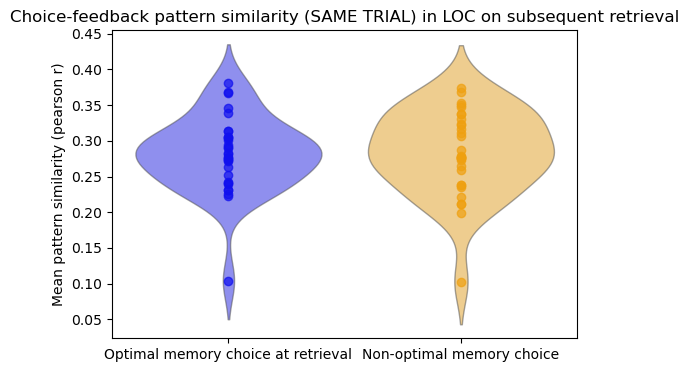

TtestResult(statistic=-0.31653249261593946, pvalue=0.7537904619835252, df=30)

In [21]:
ps_opt = []
ps_nonopt = []

for sub_num in range(1,32):
    sub_ps_opt = []
    sub_ps_nonopt = []

    beh_data = nh.get_beh_data(sub_num)

    # get correlation of each choice phase with it's own feedback phase
    stacked_choice_fb = np.vstack([all_patterns[sub_num]['fb'], all_patterns[sub_num]['choice']])
    stacked_corr_matrix = np.corrcoef(stacked_choice_fb)
    n_trials = all_patterns[sub_num]['fb'].shape[0]
    choice_fb_corrs = stacked_corr_matrix[range(n_trials), range(n_trials, 2*n_trials)]

    for i,row in beh_data.iterrows():
        if row.OldT == 1: # and row.ObjDeckMatch==1
            # get encoding trial
            enc_index = beh_data.index[beh_data.Trial == row.encTrialNum]

            if row.OptObj==1:
                sub_ps_opt.append(choice_fb_corrs[i])
            else:
                sub_ps_nonopt.append(choice_fb_corrs[i])

    # subject means
    ps_opt.append(np.mean(sub_ps_opt))
    ps_nonopt.append(np.mean(sub_ps_nonopt))

nh.simple_violin(ps_opt, ps_nonopt,
              title = 'Choice-feedback pattern similarity (SAME TRIAL) in LOC on subsequent retrieval', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Optimal memory choice at retrieval', x2_label = 'Non-optimal memory choice')

scipy.stats.ttest_rel(ps_opt, ps_nonopt)

### Other

In [ ]:
# value RSA
def value_sorted_corr(sub, col=None, sortby='Outcome'):
    beh_data = nh.get_beh_data(sub)
    if col:
        beh_data = beh_data[beh_data[col]==1]
    sorted_indices = beh_data.sort_values(by=sortby).index.to_numpy()
    corr_matrix = nh.get_corr_matrix(all_patterns, sub, 'fb')
    return corr_matrix[sorted_indices,:][:,sorted_indices]

fb = [value_sorted_corr(sub) for sub in range(1,32)]
nh.heatmap_grid(fb, 'Feedback patterns by value')

# encoding trials only
encoding_fb = [value_sorted_corr(sub, col='encT') for sub in range(1,32)]
nh.heatmap_grid(fb, 'Feedback patterns by value (new/new trials only)')

# retrieval trial grouped by value of encoding trial
retrieval = [value_sorted_corr(sub, col='OldT', sortby='ObjPP') for sub in range(1,32)]
nh.heatmap_grid(fb, 'Choice patterns at retrieval, by old card value')

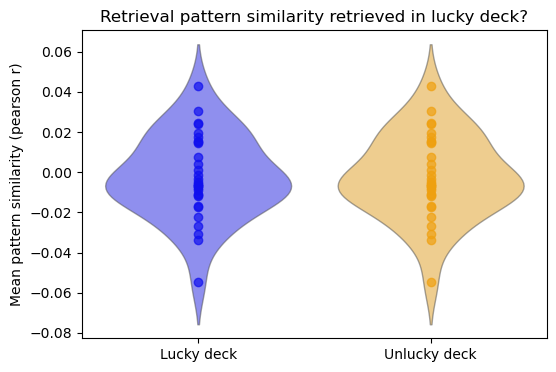

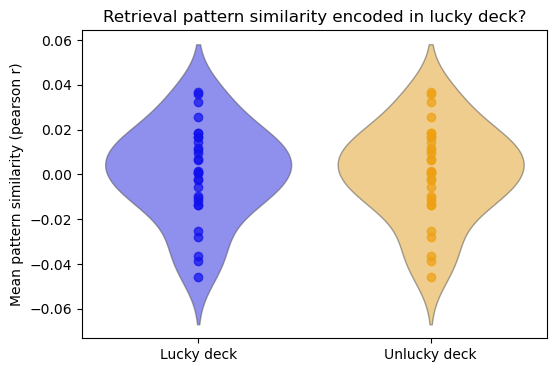

In [29]:
# retrieved/encoded in the lucky

enc_lucky, enc_unlucky, ret_lucky, ret_unlucky = [],[],[],[]

for sub_num in range(1,32):
    sub_enc_lucky, sub_enc_unlucky, sub_ret_lucky, sub_ret_unlucky = [],[],[],[]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')
    # oldt_idx = beh_data.index[beh_data.OldT==1].to_numpy()
    # beh_data = beh_data.iloc[oldt_idx]
    # oldt_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')[np.ix_(oldt_idx, oldt_idx)]

    for (i,j) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
            if beh_data.OldObjLuckyDeck.iloc[i]: sub_ret_lucky.append(corr_matrix[i,j])
            else: sub_ret_unlucky.append(corr_matrix[i,j])
            if beh_data.LuckyDeckC.iloc[j]: sub_enc_lucky.append(corr_matrix[i,j])
            else: sub_enc_unlucky.append(corr_matrix[i,j])
            
    enc_lucky.append(np.mean(sub_enc_lucky))
    enc_unlucky.append(np.mean(sub_enc_unlucky))
    ret_lucky.append(np.mean(sub_ret_lucky))
    ret_unlucky.append(np.mean(sub_ret_unlucky))
    

nh.simple_violin(ret_lucky, ret_lucky,
              title = 'Retrieval pattern similarity retrieved in lucky deck?', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Lucky deck', x2_label = 'Unlucky deck')

nh.simple_violin(enc_lucky, enc_lucky,
              title = 'Retrieval pattern similarity encoded in lucky deck?', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Lucky deck', x2_label = 'Unlucky deck')

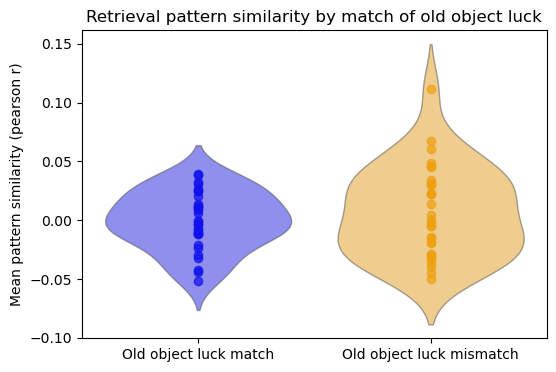

Two sample t-test result: p = 0.36375939050893225


In [32]:
# retrieved in the same deck luck as encoding

within_luck, across_luck = [],[]

for sub_num in range(1,32):
    sub_within_luck, sub_across_luck = [],[]

    beh_data = nh.get_beh_data(sub_num)
    corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')
    # oldt_idx = beh_data.index[beh_data.OldT==1].to_numpy()
    # beh_data = beh_data.iloc[oldt_idx]
    # oldt_corr_matrix = nh.get_corr_matrix(all_patterns, sub_num, 'choice')[np.ix_(oldt_idx, oldt_idx)]

    for (i,j) in zip(*np.tril_indices_from(corr_matrix, k=-1)):
        if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
            if beh_data.OldObjLuckyDeck.iloc[i] == beh_data.LuckyDeckC.iloc[j]:
                # lucky retrieval == lucky encoding 
                sub_within_luck.append(corr_matrix[i,j])
            else:
                sub_across_luck.append(corr_matrix[i,j])

    within_luck.append(np.mean(sub_within_luck))
    across_luck.append(np.mean(sub_across_luck))

nh.simple_violin(within_luck, across_luck,
              title = 'Retrieval pattern similarity by match of old object luck', ylabel='Mean pattern similarity (pearson r)',
              x1_label = 'Old object luck match', x2_label = 'Old object luck mismatch')

print('Two sample t-test result: p =', scipy.stats.ttest_ind(within_luck, across_luck).pvalue)

# PCA

In [17]:
from sklearn.decomposition import PCA
# color/cluster by:
# old trial or not
# lucky deck
# previous value

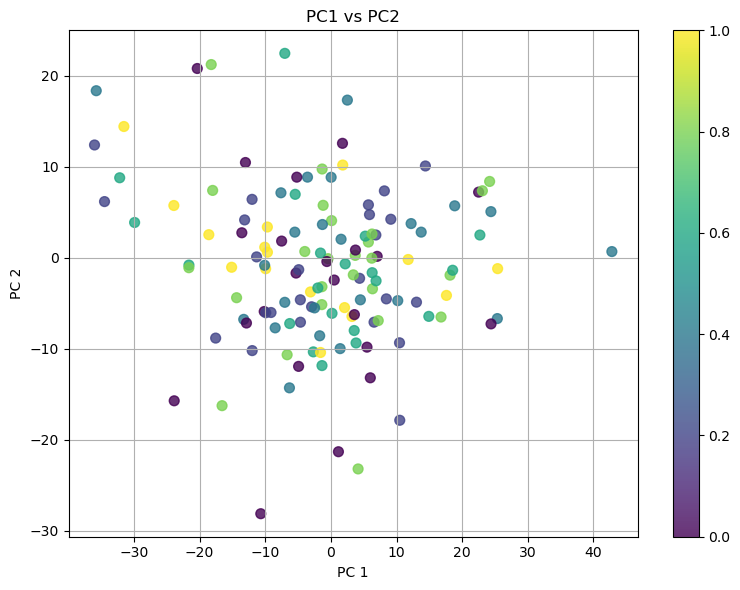

In [77]:
sub =4

choice_pc = PCA().fit_transform(all_patterns[sub]['choice'])

def plot_pcs(X_pca, pc_x=1, pc_y=2, color_by=[], color_label=''):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, pc_x - 1], X_pca[:, pc_y - 1], c=color_by, cmap='viridis', s=50, alpha=0.8)
    plt.xlabel(f'PC {pc_x}')
    plt.ylabel(f'PC {pc_y}')
    plt.title(f'PC{pc_x} vs PC{pc_y}')
    plt.colorbar(scatter, label=color_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

beh = nh.get_beh_data(sub)['ObjPP']
plot_pcs(choice_pc, 1, 2, color_by = beh)

# Decoding

1. Contralateral/ipsilateral analyses	
	- Similarity to choice pattern during feedback
		- Higher on side with chosen object
		- Reinstating object pattern
		- Reinstating deck color??
	- Similarity to choice/FB during retrieval
		- Higher on side initially presented?
		- Relationship to retrieval choice?
2. Decode reward value
	- Higher on contralateral side?
	- Reinstated?
3. NN decoding of retrieval choice
	- What is encoding FB NN trial?
		- Is decoding higher on optimal trials?
			- Just mismatch
4. vmPFC?

## contralateral vs. ipsilateral 

In [246]:
all_v1_l = nh.get_all_roi_patterns('v1L')
all_v1_r = nh.get_all_roi_patterns('v1R')
# all_loc_l = nh.get_all_roi_patterns('locL')
# all_loc_r = nh.get_all_roi_patterns('locR')

def add_left_choice(beh):
    # add columns: enc_object_left, old_object_left
    beh['enc_object_left'] = [int(row.Resp==1) if row.encT==1 else np.nan for _,row in beh.iterrows()]
    # kinda weird but if Resp (1 left, 2 right) and OldObjC (0 not chosen, 1 chosen) add up to 2, then it was on left
    # (either 1 left and 1 chosen, or 2 right and 0 not chosen)
    beh['old_object_left'] = [int(row.Resp + row.OldObjC == 2) if row.OldT==1 else np.nan for _,row in beh.iterrows()]
    return beh

### actually, it doesn't work

1. We will correlate encoding patterns to retrieval patterns, separately in right and left hemispheres. The correlation should be stronger when the object is shown on the same side both times, versus when it's not. 

- I wish we could correlate encoding pattern in left hemisphere with retrieval pattern in the right hemisphere for those side-switched trials, but the patterns are not the same size. i could PCA to reduce dimensionality but idk.

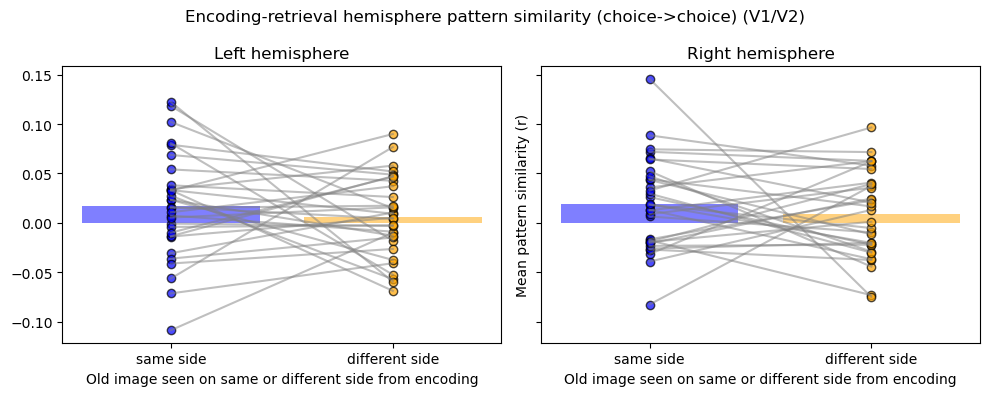

In [247]:
def con_ips(left_patterns, right_patterns, roi):
    left_same, left_diff, right_same, right_diff = [],[],[],[]

    for sub_num in range(1,32):
        sub_left_same, sub_left_diff, sub_right_same, sub_right_diff = [],[],[],[]

        beh_data = add_left_choice(nh.get_beh_data(sub_num))
        left_corr_matrix = nh.get_corr_matrix(left_patterns, sub_num, 'choice')
        right_corr_matrix = nh.get_corr_matrix(right_patterns, sub_num, 'choice')

        for (i,j) in zip(*np.tril_indices_from(left_corr_matrix, k=-1)):
            # for each pair of trials
            if beh_data.OldT.iloc[i] == 1 and beh_data.encTrialNum.iloc[i] == beh_data.Trial.iloc[j]:
                # i is a retrieval trial and j is its corresponding encoding trial 
                if beh_data.old_object_left.iloc[i] == beh_data.enc_object_left.iloc[j]:
                    # the sides match
                    sub_left_same.append(left_corr_matrix[i,j])
                    sub_right_same.append(right_corr_matrix[i,j])
                else:
                    sub_left_diff.append(left_corr_matrix[i,j])
                    sub_right_diff.append(right_corr_matrix[i,j])

        left_same.append(np.mean(sub_left_same))
        left_diff.append(np.mean(sub_left_diff))
        right_same.append(np.mean(sub_right_same))
        right_diff.append(np.mean(sub_right_diff))

    nh.double_bar([left_same, left_diff, right_same, right_diff], ['same side', 'different side', 'same side', 'different side'],
                    title = f'Encoding-retrieval hemisphere pattern similarity (choice->choice) ({roi})', 
                    ax_titles = ['Left hemisphere', 'Right hemisphere'],
                    ylabel='Mean pattern similarity (r)',
                    xlabel='Old image seen on same or different side from encoding')
# print('One sample t-test result: p =', scipy.stats.ttest_1samp(sub_avg_enc_ret_corr, 0).pvalue)

con_ips(all_v1_l, all_v1_r, roi='V1/V2')
# con_ips(all_loc_l, all_loc_r, roi='LOC')

## decoding reward feedback

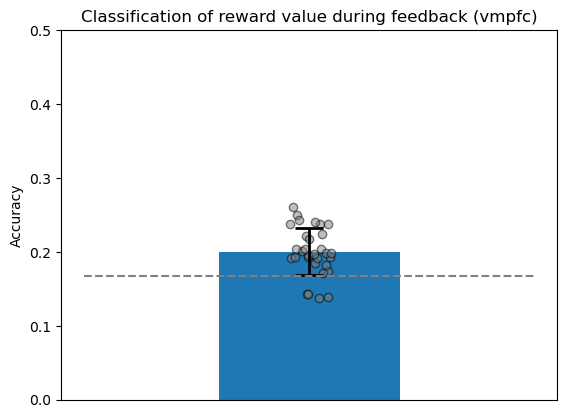

In [264]:
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, LeaveOneOut
from sklearn.linear_model import LogisticRegression
import numpy as np

def decode_reward(X, y, method='kfold', n_splits=5, random_state=42):
    """
    Run cross-validated decoding of reward from LOC patterns.
    Parameters:
    - X: (n_trials, n_voxels)
    - y: reward values (labels or continuous)
    - kind: 'classification' or 'regression'
    - n_splits: number of cross-validation folds
    Returns:
    - scores: array of CV scores
    - mean_score: average score across folds
    """
    model=LogisticRegression(max_iter=500)
    if method == 'kfold':
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return scores, np.mean(scores)
    else:
        cv = LeaveOneOut()
        scores = cross_val_predict(model, X, y, cv=cv, method='decision_function')
        return scores

acc = []
for sub in range(1,32):
    rewards = nh.get_beh_data(sub).Outcome.to_numpy().astype(str)
    patterns = all_patterns[sub]['fb']
    _, mean_acc = decode_reward(patterns, rewards, method='kfold', n_splits=10)
    acc.append(mean_acc)

plt.figure()
plt.title('Classification of reward value during feedback (vmpfc)')
plt.bar(0,np.mean(acc))
plt.errorbar(x=0, y=np.mean(acc), yerr=np.std(acc), color='black', capsize=10, linewidth=2, markeredgewidth=2)
jitter = np.zeros(len(acc)) + (np.random.rand(len(acc))-0.5)/5
plt.scatter(jitter, acc, color='gray', edgecolor='black', alpha=0.5)
plt.hlines(y=1/6, xmin=-1, xmax=1, linestyle='--', color='gray')
plt.ylim(0,0.5)
plt.ylabel('Accuracy')
plt.xticks([])
plt.show()

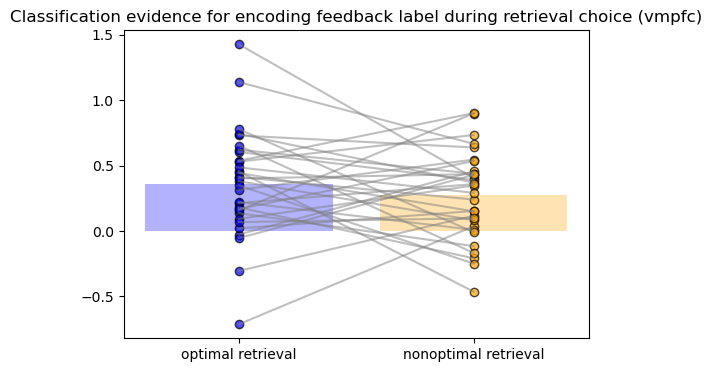

TtestResult(statistic=1.0239929849612213, pvalue=0.3140251943999816, df=30)

In [266]:
# is classification evidence higher on trials with OptObj == 1?
avg_opt_evidence = []
avg_nonopt_evidence = []

for sub in range(1,32):
    beh = nh.get_beh_data(sub)
    oldt_and_valid_enc_mask = beh.encTrialNum.isin(beh.Trial)

    # fit classifier on all the other trials, feedback period
    fb_patterns = all_patterns[sub]['fb'][~oldt_and_valid_enc_mask]
    reward_labels = beh.Outcome.to_numpy().astype(str)[~oldt_and_valid_enc_mask]
    model = LogisticRegression(max_iter=500)
    model.fit(fb_patterns, reward_labels)

    # Get decision function on choice patterns
    choice_patterns = all_patterns[sub]['choice'][oldt_and_valid_enc_mask]
    decision_scores = model.decision_function(choice_patterns)

    # gget evidence for the 'correct' labels; i.e., the reward of the encoding trial
    enc_reward_labels = [beh.loc[beh.index[beh.Trial == row.encTrialNum][0], 'Outcome'].astype(str) for _,row in beh[oldt_and_valid_enc_mask].iterrows()]
    label_map = {label: i for i, label in enumerate(model.classes_)}
    evidence = np.array([decision_scores[i, label_map[label]] for i, label in enumerate(enc_reward_labels)])

    # Group by OptObj
    opt_mask = beh[oldt_and_valid_enc_mask].OptObj==1
    opt_evidence = evidence[opt_mask]
    nonopt_evidence = evidence[~opt_mask]

    avg_opt_evidence.append(np.mean(opt_evidence))
    avg_nonopt_evidence.append(np.mean(nonopt_evidence))


nh.simple_bar(avg_opt_evidence, avg_nonopt_evidence, x1_label = 'optimal retrieval', x2_label='nonoptimal retrieval',
              title = 'Classification evidence for encoding feedback label during retrieval choice (vmpfc)')

scipy.stats.ttest_rel(avg_opt_evidence, avg_nonopt_evidence)